In [1]:
# Python program to explain cv2.imread() method 
  
# importing cv2  
import pandas as pd
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import random
from random import randint
from scipy import stats
from scipy.stats import poisson

from keras.models import load_model

import seaborn as sn
import itertools
from matplotlib.gridspec import GridSpec

import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def two_plot_summary_v4(grid_data, data_from_patch, patch_lon, patch_lat, leg_loc, rad1, lon_lat=True):
    
    test_x = np.array(data_from_patch["test_x"])
    test_y = np.array(data_from_patch["test_y"])
    
    pred_x = np.array(data_from_patch["pred_x"])
    pred_y = np.array(data_from_patch["pred_y"])
    
    test_class = np.array(data_from_patch["class"])
    
    prob_agn  = np.array(data_from_patch["prob_agn"])
    prob_psr  = np.array(data_from_patch["prob_psr"])
    prob_fake = np.array(data_from_patch["prob_fake"])
    
    prob_loc =  np.array(data_from_patch["probability"])
    
    #print(test_x[0], pred_x[0])
    figure, ax = plt.subplots(1,2,figsize=(10, 10)) 
    
    ax[0].imshow(grid_data, origin='lower')

    for con in range(len(pred_x)):
            
        circle = plt.Circle((pred_x[con], pred_y[con]), rad1, fill=False, color="white")
        ax[0].add_artist(circle)
        ax[0].add_patch(circle) 
        
        square = plt.Rectangle((pred_x[con]-3, pred_y[con]-3), 6, 6, angle=0.0, fill=False, color="white")
        ax[0].add_artist(square)
        ax[0].add_patch(square) 
        
        #if (test_class[con] == 2):
        #    ax[0].text(pred_x[con]-2, pred_y[con]-1, f"{prob_loc[con]:0.1f}", color="white", fontweight='bold')
        
    con_cross_agn = 0
    con_cross_psr = 0
    for con in range(len(test_x)):    
        
        if test_class[con] == 0:
            con_cross_agn = con_cross_agn + 1
        
            crosses_agn, = ax[0].plot(test_x[con], test_y[con], 'x', color="red", label="Test PS",\
                                  mew=2, ms=10) #linewidth=3, markersize=10)
            
        if test_class[con] == 1:
            
            con_cross_psr = con_cross_psr + 1
        
            crosses_psr, = ax[0].plot(test_x[con], test_y[con], 'x', color="blue", label="Test PS",\
                                  mew=2, ms=10) #linewidth=20, markersize=10)
        
    if con_cross_agn > 0 and con_cross_psr > 0:    
        
        ax[0].legend([crosses_agn, crosses_psr, circle], ['True AGN', 'True PSR', 'UNEK PS'], loc=leg_loc)  
        
    if con_cross_agn > 0 and con_cross_psr == 0:    
        
        ax[0].legend([crosses_agn, circle], ['True AGN', 'UNEK PS'], loc=leg_loc)  
        
    if con_cross_agn == 0 and con_cross_psr >0 :    
        
        ax[0].legend([crosses_psr, circle], ['True PSR', 'UNEK PS'], loc=leg_loc)  
    
    
    ax[0].set_aspect(1)
    ax[0].set_xlim(-0.5,63.5)
    ax[0].set_ylim(-0.5,63.5)
    
    #######################################
    #PIE charts
    #######################################
               
    con_agn = 0
    con_psr = 0
    con_fake = 0
    
    size = 1000
    con_ps_class = 0
    
    mc_count = 0 
    
    #print("sources with classification", len(pred_x))
    
    for con in range(len(pred_x)):
        
        #print(prob_agn[con], prob_psr[con], prob_fake[con])
        
        if prob_agn[con] + prob_psr[con] + prob_fake[con] > 0:
        
            xpos = pred_x[con]
            ypos = pred_y[con]

            r1 = prob_agn[con]
            r2 = r1 + prob_psr[con]

            x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
            y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
            xy1 = np.column_stack([x, y])
            s1 = np.abs(xy1).max()

            x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 20)).tolist()
            y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 20)).tolist()
            xy2 = np.column_stack([x, y])
            s2 = np.abs(xy2).max()

            x = [0] + np.cos(np.linspace(2 * np.pi * r2, 2 * np.pi, 20)).tolist()
            y = [0] + np.sin(np.linspace(2 * np.pi * r2, 2 * np.pi, 20)).tolist()
            xy3 = np.column_stack([x, y])
            s3 = np.abs(xy3).max()
            
            ax[1].scatter(xpos, ypos, marker=xy1,
                          s=s1 ** 2 * size, facecolor='red')

            ax[1].scatter(xpos, ypos, marker=xy2,
                          s=s2 ** 2 * size, facecolor='blue')

            ax[1].scatter(xpos, ypos, marker=xy3,
                          s=s3 ** 2 * size, facecolor='magenta')
    
            if ((prob_agn[con] >= prob_psr[con]) & (prob_agn[con] >= prob_fake[con])):
                ax[1].text(xpos-2, ypos+1, f"{prob_agn[con]*100:2.0f}", color="white", fontweight='bold')
                
                if test_class[con]!=0.0:
                    circle_fake = plt.Circle((xpos, ypos), 4.1, fill=False, color="black", linestyle='--')
                    ax[1].add_artist(circle_fake)
                    ax[1].add_patch(circle_fake)
                    
                    mc_count = mc_count + 1
                
            if ((prob_psr[con] > prob_agn[con]) & (prob_psr[con] >=prob_fake[con])):
                ax[1].text(xpos-4, ypos-1, f"{prob_psr[con]*100:2.0f}", color="white", fontweight='bold')
                
                if test_class[con]!=1.0:
                    circle_fake = plt.Circle((xpos, ypos), 4.1, fill=False, color="black", linestyle='--')
                    ax[1].add_artist(circle_fake)
                    ax[1].add_patch(circle_fake)
                    
                    mc_count = mc_count + 1
                
            if ((prob_fake[con] > prob_agn[con]) & (prob_fake[con] > prob_psr[con])):
                ax[1].text(xpos-2, ypos-3, f"{prob_fake[con]*100:2.0f}", color="white", fontweight='bold')
                
                if test_class[con]!=2.0:
                    circle_fake = plt.Circle((xpos, ypos), 4.1, fill=False, color="black", linestyle='--')
                    ax[1].add_artist(circle_fake)
                    ax[1].add_patch(circle_fake)
                    
                    mc_count = mc_count + 1

    #Legend
    agn_marker = ax[1].scatter(70, 70, marker="o", s=40, color="red")
    psr_marker = ax[1].scatter(70, 70, marker="o", s=40, color="blue")
    fake_marker = ax[1].scatter(70, 70, marker="o", s=40, color="magenta")
    
    mis_class = ax[1].scatter(70, 70, marker="_", s=40, color="black")
    
    if mc_count > 0:
    
        ax[1].legend([agn_marker, psr_marker, fake_marker, mis_class], ["AGN Prob (%)", "PSR Prob (%)", \
                                                                        "FAKE Prob (%)", "Misclassified"],\
                                                                          fontsize = 11, loc=leg_loc)
    if mc_count == 0:
    
        ax[1].legend([agn_marker, psr_marker, fake_marker], ["AGN Prob (%)", "PSR Prob (%)", \
                                                                        "FAKE Prob (%)"],\
                                                                          fontsize = 11, loc=leg_loc)
        
            
    ax[1].set_aspect(1)
    ax[1].set_xlim(0,64)
    ax[1].set_ylim(0,64)

    #AXIS values
    for con in range(2):
    
        ax[con].set_xticks([0,10,20,30,40,50,60])
        ax[con].set_yticks([0,10,20,30,40,50,60])
        
    if lon_lat:  
    
        lon_xaxis = []    
        lat_yaxis = []

        for decs in range(7):
            yval = 0
            xval = 10*decs

            lon_ps, lat_ps = get_lb_from_pixel(pixel_id(yval*2, xval*2,128), [patch_lon, patch_lat])

            lon_xaxis.append("% .0f"% lon_ps)

            yval = 10*decs
            xval = 0

            lon_ps, lat_ps = get_lb_from_pixel(pixel_id(yval*2, xval*2,128), [patch_lon, patch_lat])

            lat_yaxis.append("% .0f"% lat_ps)

            #print(lon_ps, lat_ps)

        for con in range(2):    

            ax[con].set_xticklabels(lon_xaxis)
            ax[con].set_yticklabels(lat_yaxis)

            ax[con].set_xlabel("Galactic Longitude (°)", fontsize = 14)
            ax[con].set_ylabel("Galactic Latitude (°)", fontsize = 14)
    else:
        for con in range(2):    

            ax[con].set_xlabel("x-pixels", fontsize = 14)
            ax[con].set_ylabel("y-pixels", fontsize = 14)
    
    
    plt.rc('xtick', labelsize=12) 
    plt.rc('ytick', labelsize=12)
    plt.show()
    
    return

In [4]:
def patch_two_plots(patch, radius, lon_lat, legend_loc):
    
    print(patch)

    test_asimov = np.load(f"{path_to_test}/test_image_{patch}.npy")
    test_mask = np.load(f"{path_to_test}/test_masks_{patch}.npy")

    test_asimov_sum = np.sum(test_asimov, axis=0)
    test_poisson = np.random.poisson(test_asimov_sum)

    data_from_patch = stat_file[((stat_file["patch_number"]==patch) & (stat_file["stat_code"]!=3))]
    id_class = stat_file[((stat_file["patch_number"]== patch) & (stat_file["stat_code"]!=3))].iloc[:,13]
    position = stat_file[((stat_file["patch_number"]== patch) & (stat_file["stat_code"]!=3))].iloc[:,11:13]
    distance_dg = stat_file[((stat_file["patch_number"]== patch) & (stat_file["stat_code"]!=3))].iloc[:,6]
    snr_center = stat_file[((stat_file["patch_number"]== patch) & (stat_file["stat_code"]!=3))].iloc[:,-5]

    #prediction of classes
    #classify the point sources in poisson patch
    ps_patch_asimov_list, ps_patch_poisson_list, ps_pred_list = classify_patch_stat(f"test_image_{patch}.npy",
                                                                                    test_asimov_sum, position, 
                                                                                    id_class, distance_dg, 
                                                                                    cnn_model, snr_center)

    print(test_asimov_sum.shape)
    print("Patch center at lon = %.2f and lat = %.2f"%(data_from_patch["test_lon_patch"].iloc[0],\
                                                       data_from_patch["test_lat_patch"].iloc[0]))

    prob_pred_df = pd.DataFrame({"prob_agn":ps_pred_list[:,10], "prob_psr":ps_pred_list[:,11],\
                                "prob_fake":ps_pred_list[:,12]})

    data_from_patch = data_from_patch.reset_index()

    data_from_patch_prob = pd.concat([data_from_patch, prob_pred_df], axis=1)

    two_plot_summary_v4(test_poisson[:,:,1], data_from_patch_prob, data_from_patch["test_lon_patch"].iloc[0],\
                        data_from_patch["test_lat_patch"].iloc[0], legend_loc, radius, lon_lat)

In [5]:
def RotMatrixY(psi, isdeg = True):
    if isdeg:
        return np.array([[np.cos(np.radians(psi)), 0.0, -np.sin(np.radians(psi))],[0.0, 1.0, 0.0],\
                         [np.sin(np.radians(psi)), 0.0, np.cos(np.radians(psi))]])
    else:
        return np.array([[np.cos(psi), 0.0, -np.sin(psi)],[0.0, 1.0, 0.0],[np.sin(psi), 0.0, np.cos(psi)]]) 
    
def RotMatrixZ(psi, isdeg = True):
    if isdeg:
        return np.array([[np.cos(np.radians(psi)), np.sin(np.radians(psi)), 0.0],\
                         [-np.sin(np.radians(psi)), np.cos(np.radians(psi)), 0.0],[0.0, 0.0, 1.0]])
    else:
        return np.array([[np.cos(psi), np.sin(psi), 0.0],[-np.sin(psi), np.cos(psi), 0.0],[0.0, 0.0, 1.0]])
    
def sph2xyz(r, theta, phi, isdeg = True):
    if isdeg:
        return np.array([r*np.sin(np.radians(theta))*np.cos(np.radians(phi)), \
                         r*np.sin(np.radians(theta))*np.sin(np.radians(phi)), r*np.cos(np.radians(theta))])
    else:
        return np.array([r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)])
    
def xyz2sph(x, y, z, isdeg= True, is_lat = False):
    r = np.sqrt(x*x + y*y + z*z)
    if isdeg:
        phi = np.degrees(np.arctan2(y,x))
        lat = np.degrees(np.arctan2(z, np.sqrt(x*x + y*y)))
        if is_lat:
            return np.array([r, lat, phi])
        else:
            return np.array([r, 90. - lat, phi])
    else:
        phi = np.arctan2(y,x)
        lat = np.arctan2(z, np.sqrt(x*x + y*y))
        if is_lat:
            return np.array([r, lat, phi])
        else:
            return np.array([r, np.pi/2.0 - lat, phi])

def get_lb_from_pixel(pixel_id, lb_centre, xsize=128, isdeg = True, is_lat = True): ##if input angles are in degree use 'isdeg = True'
######### Generate (l,b) coordinate map of 10x10deg patch ######
    
    #Following the suggestions of CA mail
    if (xsize == 100):
        coord_range = np.linspace(-4.95, 4.95, xsize)
    
    if (xsize == 128):
        coord_range = np.linspace(-4.9609375, 4.9609375, xsize)
    
    X, Y = np.meshgrid(coord_range, coord_range)
    lonlat_patch = list(zip(np.flip(X.flatten()), Y.flatten()))
    ######### Get rotation matrix used to rotate the original centre to (0., 0.) #########
    l_centre, b_centre = lb_centre
    r = np.dot(RotMatrixY(-b_centre), RotMatrixZ(l_centre))
    ######### 
    
    lon_PS_rotated, lat_PS_rotated = lonlat_patch[int(pixel_id)]
     
    #x_pixel_normal = int(pixel_id % xsize)
    #y_pixel_normal = int(pixel_id / xsize)
        
    xyz_PS_rotated = sph2xyz(1., 90. - lat_PS_rotated, lon_PS_rotated)
    x_PS, y_PS, z_PS = np.array(np.dot(r.T, xyz_PS_rotated), dtype = 'float32')
    #xyz_centre = sph2xyz(1., 90. - b_centre, l_centre)
    r, b_PS, l_PS = xyz2sph(x_PS, y_PS, z_PS, isdeg = isdeg, is_lat = is_lat)
    
    if l_PS < 0:
        l_PS = 360 + l_PS
    
    return l_PS, b_PS

def pixel_id(row, col, xsize_patch):
    
    return xsize_patch*row + col

#### Classify point sources using the info from stat files

In [6]:
def get_samples(ims):
    return (poisson.rvs(ims) - norm_mean) / norm_std

def classify_patch_stat(patch, test_image_npy, ps_position, id_class, distance_dg, cnn_model, snr_center):
    
    image_name = f"test_image_{patch}.npy"
    
    #dimensions of test_image_poisson
    xsize = 64
    
    #box dimensions
    r_b=7
    box_inf = 3
    box_sup = 4
    
    #number of point source with positions in xmin, xmax, ymin, ymax format
    ps_length = len(ps_position)
    
    #list of point source patches when is possible
    ps_patch_asimov_list = np.zeros((ps_length, 7, 7, 5))
    ps_patch_poisson_list = np.zeros((ps_length, 7, 7, 5))
    
    #list of test adn predictions and extra data to compare with ROC-AUC data
    ps_pred_list = np.zeros((ps_length, 15), dtype=object)
    
    for ps_number in range(ps_length):
    
        #print(id_class)
        #print(ps_number, ps_length, id_class.iloc[ps_number])
        id_ps = id_class.iloc[ps_number]

        x_ps = int(ps_position["pred_x"].iloc[ps_number])
        y_ps = int(ps_position["pred_y"].iloc[ps_number])

        snr_ct = snr_center.iloc[ps_number]
        
        #box around ps, for radius of 7x7
        #xmin_b, xmax_b, ymin_b, ymax_b = max(0,x_ps-box_inf),min(xsize-1,x_ps+box_sup),\
        #                                 max(0,y_ps-box_inf),min(xsize-1,y_ps+box_sup)

        #improved version of the cut. here we correctly consider superior limits inclusively
        xmin_b, xmax_b, ymin_b, ymax_b = max(0,x_ps-box_inf),min(xsize,x_ps+box_inf+1),\
                                         max(0,y_ps-box_inf),min(xsize,y_ps+box_inf+1)

        
        prob_test_agn = 0
        prob_test_psr = 0
        prob_test_fake = 0
        
        ps_pred_list[ps_number,0] = image_name
        ps_pred_list[ps_number,1] = id_ps
        ps_pred_list[ps_number,2] = x_ps
        ps_pred_list[ps_number,3] = x_ps
        ps_pred_list[ps_number,4] = y_ps
        ps_pred_list[ps_number,5] = y_ps
        ps_pred_list[ps_number,13] = distance_dg.iloc[ps_number]
        ps_pred_list[ps_number,14] = snr_center.iloc[ps_number]
        
        ps_patch_test = np.zeros((1,7,7,5))
        
        #if ( x_ps >= 3 or x_ps <= 61 or y_ps >= 3 or y_ps <= 61 ):
        if (((xmax_b-xmin_b) == r_b) and ((ymax_b-ymin_b) == r_b)):
            #ps patch from 64x64 asimov (for future comparison) and poisson patch  
            ps_patch_asimov = test_image_npy[ymin_b:ymax_b, xmin_b:xmax_b]
            
            #ps_patch_poisson = np.random.poisson(ps_patch_asimov, ps_patch_asimov.shape).astype(float)
            ps_patch_poisson = (poisson.rvs(ps_patch_asimov) - norm_mean) / norm_std
            
            #dataset with one position just to evaluate with cnn_predict
            ps_patch_test[0,:,:,:] = ps_patch_poisson[:,:,:]
            
            #list of patches for future use
            ps_patch_asimov_list[ps_number, :, :, :] = ps_patch_asimov[:,:,:]
            ps_patch_poisson_list[ps_number, :, :, :] = ps_patch_poisson[:,:,:]
            
            #one-hot encoder of test id_class
            if int(id_ps) == 0:
                prob_test_agn = 1
            if int(id_ps) == 1:   
                prob_test_psr = 1
            if int(id_ps) == 2:
                prob_test_fake = 1
                
            #cnn prediction on one ps patch
            ps_pred_prob = cnn_model.predict(ps_patch_test)
                
            ps_pred_list[ps_number,6] = 1 #7x7 box
            
            ps_pred_list[ps_number,7] = prob_test_agn
            ps_pred_list[ps_number,8] = prob_test_psr
            ps_pred_list[ps_number,9] = prob_test_fake
                
            ps_pred_list[ps_number,10] = ps_pred_prob[0,0]
            ps_pred_list[ps_number,11] = ps_pred_prob[0,1]
            ps_pred_list[ps_number,12] = ps_pred_prob[0,2]
            
            
        else:
            ps_pred_list[ps_number,6] = 0
            
    return ps_patch_asimov_list, ps_patch_poisson_list, ps_pred_list

In [7]:
xsize  = 64

path_solid = f"/home/bapanes/Research-Now/Gamma-Ray-Point-Source-Detector"

cnn_model_file = f"{path_solid}/models/cnn_model.h5"
pkl_file = f"{path_solid}/models/standard_norm_vals.pkl"

In [8]:
with open(pkl_file,"rb") as f:
    [norm_mean, norm_std] = pickle.load(f)

In [9]:
path_to_test = f"{path_solid}/data-test/data-768-F0-B1"

path_to_test_csv = f"{path_to_test}/test.csv"
path_to_stat_csv = f"{path_solid}/outputs-csv/unek_evaluation_test.csv"

In [10]:
cnn_model = load_model(cnn_model_file)

In [11]:
stat_file = pd.read_csv(f"{path_to_stat_csv}", sep=",")

In [12]:
stat_file[((stat_file["stat_code"]==1))]

,stat_code,pred_con,pred_lon,pred_lat,test_lon,test_lat,distance_degree,distance_pixel,test_flux_1000,catalog,patch_number,pred_y,pred_x,class,test_y,test_x,test_lon_patch,test_lat_patch,probability,test_flux_10000,snr_center_pred,class_ps,snr_center_test,sbr_center_pred,sbr_center_test
13,1.0,13.0,110.749046,88.767769,109.428358,85.871788,2.896447,18.788294,1.052663e-10,400.0,1.0,62.0,35.0,2.0,45.0,43.0,135.0,84.149733,0.177005,8.762012e-13,0.703147,0.0,1.172326,0.336407,0.710501
18,1.0,18.0,344.129696,79.782249,346.061740,81.085304,1.341850,8.246211,1.527258e-10,400.0,3.0,12.0,0.0,2.0,20.0,2.0,-45.0,84.149733,0.295420,1.878541e-11,43.079856,0.0,1.866212,17.784571,1.157412
21,1.0,21.0,328.031813,85.318962,323.596629,85.576886,0.436197,2.236068,9.034085e-11,400.0,3.0,40.0,25.0,2.0,41.0,27.0,-45.0,84.149733,0.201896,8.624861e-12,0.147417,0.0,1.155654,0.064255,0.650706
48,1.0,48.0,139.890045,79.172585,126.264546,78.898563,2.599961,16.124515,3.006456e-11,400.0,6.0,45.0,0.0,2.0,37.0,14.0,112.5,78.284148,0.275411,6.347299e-12,4.983970,0.0,0.370170,2.224701,0.179401
88,1.0,88.0,11.811967,81.201836,3.450296,82.323738,1.638522,10.049876,2.181540e-10,400.0,11.0,60.0,0.0,2.0,61.0,10.0,-22.5,78.284148,0.839573,7.560038e-11,24.116344,0.0,1.079489,11.085499,0.642370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5656,1.0,5656.0,80.427406,-87.376785,80.773979,-87.050222,0.326996,2.236068,2.606355e-10,400.0,764.0,8.0,22.0,2.0,9.0,20.0,45.0,-84.149733,0.531707,9.643177e-13,3.445334,0.0,2.555774,1.692649,2.264582
5667,1.0,5667.0,165.827240,-86.419815,166.624282,-83.857349,2.563294,15.811388,4.663595e-11,400.0,765.0,14.0,20.0,2.0,27.0,11.0,135.0,-84.149733,0.422657,2.618626e-12,0.014998,0.0,0.481892,0.006936,0.257500
5673,1.0,5673.0,284.648819,-84.256218,260.824052,-84.631176,2.319581,14.212670,1.946559e-10,400.0,766.0,13.0,0.0,2.0,22.0,11.0,-135.0,-84.149733,0.244702,7.365080e-12,9.542598,0.0,1.596255,4.333750,1.003361
5677,1.0,5677.0,312.867836,-88.953697,298.784723,-85.862066,3.133421,19.313208,2.073714e-09,400.0,767.0,1.0,32.0,2.0,19.0,39.0,-45.0,-84.149733,0.262869,2.194623e-10,0.767124,0.0,5.372315,0.359645,7.084894


### Full pipeline plots

#### High Latitude (>45 degrees)

647
(64, 64, 5)
Patch center at lon = -95.62 and lat = -41.81


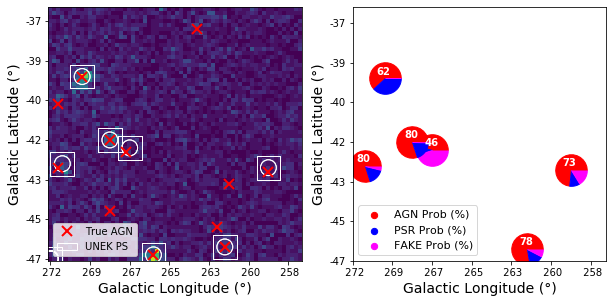

In [13]:
patch_two_plots(647, 2, True, "lower left")

647
(64, 64, 5)
Patch center at lon = -95.62 and lat = -41.81


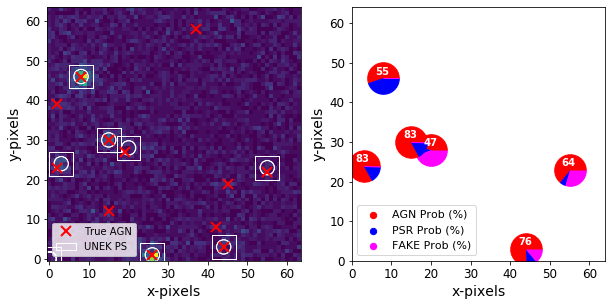

In [14]:
patch_two_plots(647, 1.8, False, "lower left")

#### Low latitude (<10 degrees)

408
(64, 64, 5)
Patch center at lon = 90.00 and lat = -4.78


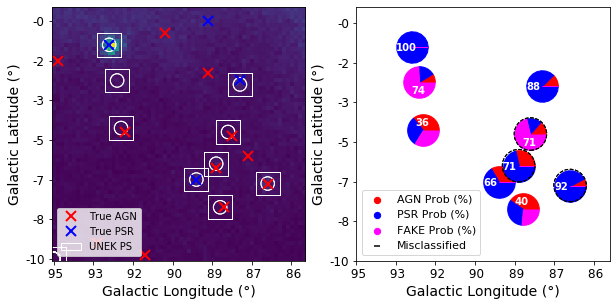

In [19]:
patch_two_plots(408, 1.7, True, "lower left")

408
(64, 64, 5)
Patch center at lon = 90.00 and lat = -4.78


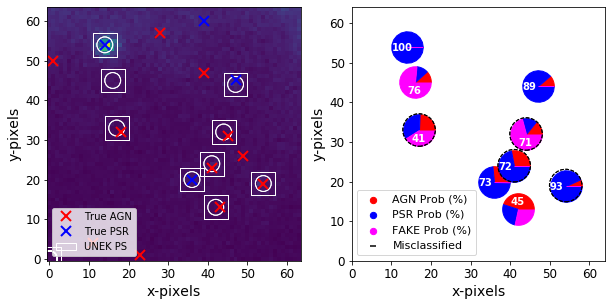

In [20]:
patch_two_plots(408, 2, False, "lower left")